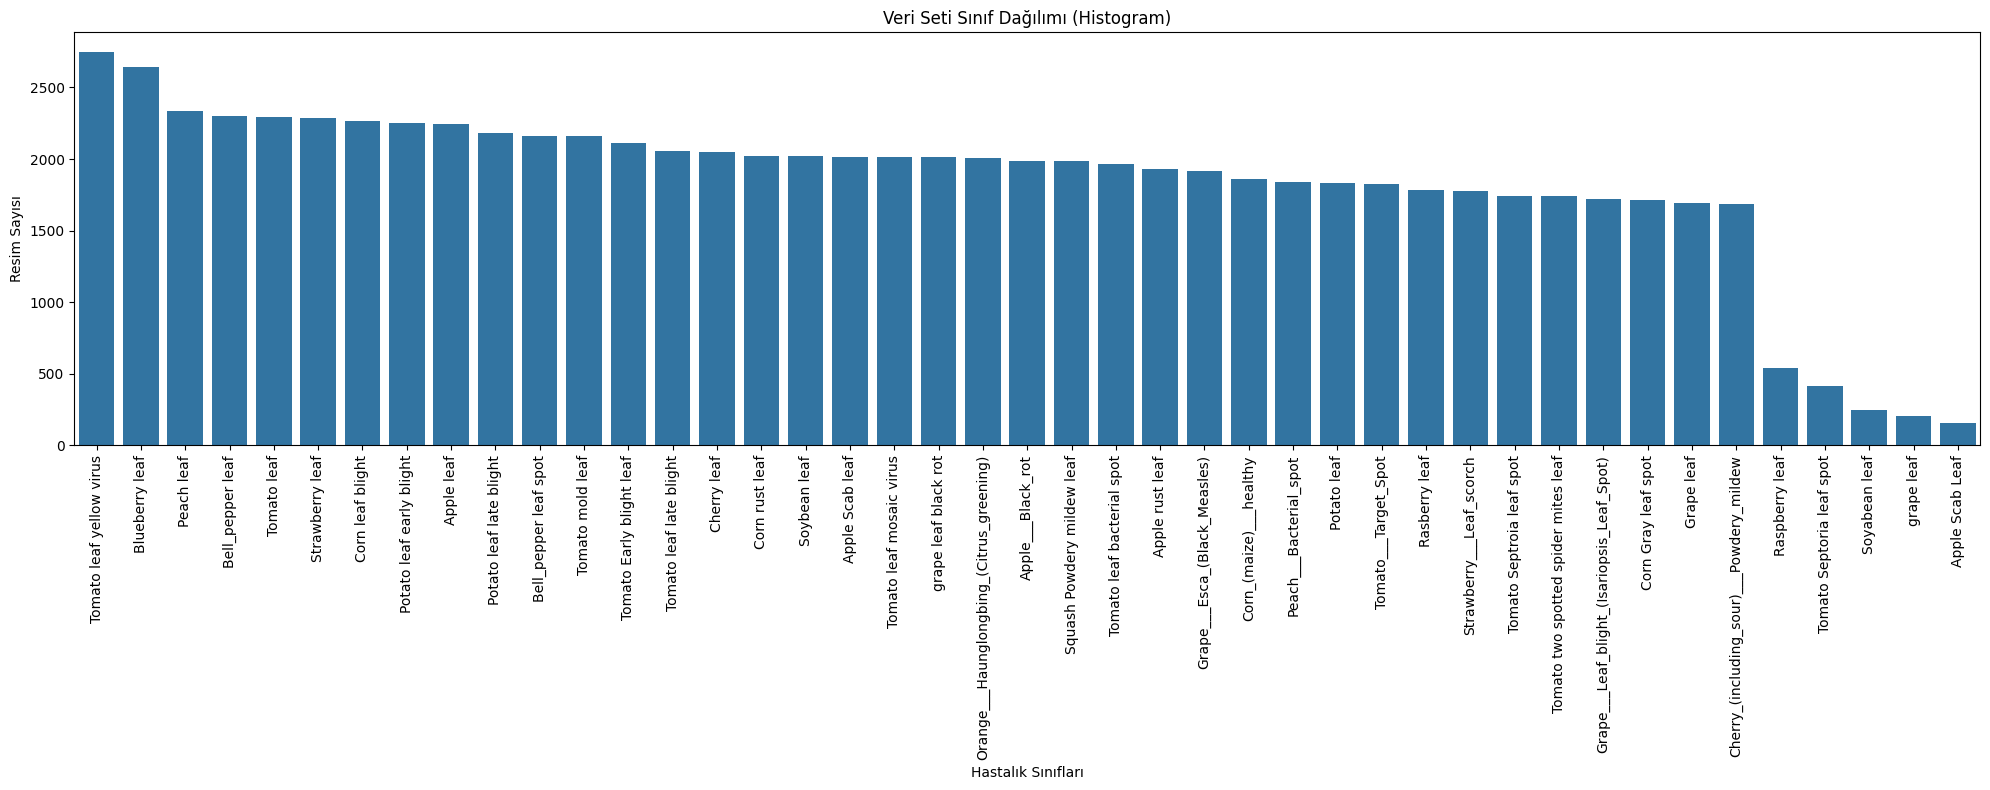

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(20, 8))
sns.countplot(x=dataset.veriler['class'], order=dataset.veriler['class'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Veri Seti Sınıf Dağılımı (Histogram)")
plt.xlabel("Hastalık Sınıfları")
plt.ylabel("Resim Sayısı")
plt.tight_layout()
plt.show()

In [2]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import time
import random # Rastgele seçim için gerekli
from tqdm import tqdm 
import urllib.parse # Dosya ismindeki %20 gibi karakterleri düzeltmek için

# --- AYARLAR ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

# !!! DOSYA YOLLARINI KONTROL ET !!!
CSV_DOSYASI = r"C:\Users\FERHAT\Downloads\egitim_icin_hazir.csv"
ANA_KLASOR = r"C:\Users\FERHAT\Plant\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train"

BATCH_SIZE = 16 
LEARNING_RATE = 0.0001
EPOCHS = 15
RESIM_BOYUTU = 224 

class TankVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}
        
        # --- AKILLI DOSYA BULUCU ---
        print("Dosyalar taranıyor (Bu işlem bir kez yapılır)...")
        self.dosya_haritasi = {}
        
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                # Hem normal ismini hem de "unquote" edilmiş (düzeltilmiş) ismini kaydet
                tam_yol = os.path.join(root, file)
                self.dosya_haritasi[file] = tam_yol
                
                # Örn: "resim%201.jpg" varsa "resim 1.jpg" olarak da haritaya ekle
                duzgun_isim = urllib.parse.unquote(file)
                if duzgun_isim != file:
                    self.dosya_haritasi[duzgun_isim] = tam_yol
                
        print(f"Tarama Bitti. {len(self.dosya_haritasi)} adet dosya yolu hafızaya alındı.")

    def __len__(self): return len(self.veriler)

    def __getitem__(self, idx):
        try:
            dosya_adi_csv = str(self.veriler.iloc[idx, 0])
            sinif_ismi = str(self.veriler.iloc[idx, 1])
            
            # İsim temizliği
            if "?" in dosya_adi_csv: dosya_adi_csv = dosya_adi_csv.split('?')[0]
            
            # URL encode temizliği (%28 -> ( gibi)
            dosya_adi_temiz = urllib.parse.unquote(dosya_adi_csv)

            # 1. YÖNTEM: Haritadan bak
            hedef_yol = self.dosya_haritasi.get(dosya_adi_csv)
            
            # 2. YÖNTEM: Temizlenmiş isimle bak
            if hedef_yol is None:
                hedef_yol = self.dosya_haritasi.get(dosya_adi_temiz)

            # 3. YÖNTEM: Uzantı hatası varsa düzelt (JPG.jpg sorununu çözer)
            if hedef_yol is None and dosya_adi_csv.lower().endswith(".jpg.jpg"):
                 tek_uzanti = dosya_adi_csv[:-4]
                 hedef_yol = self.dosya_haritasi.get(tek_uzanti)

            # Eğer dosya HÂLÂ yoksa HATA VERME, BAŞKA RESİM SEÇ (Sonsuz döngü çözümü)
            if hedef_yol is None:
                # print(f"Atlanıyor (Bulunamadı): {dosya_adi_csv}") # Konsolu kirletmesin diye kapattım
                yeni_idx = random.randint(0, len(self.veriler) - 1)
                return self.__getitem__(yeni_idx)

            image = Image.open(hedef_yol).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            
            if self.transform: 
                image = self.transform(image)
                
            return image, label
            
        except Exception as e:
            # Resim bozuksa veya açılamazsa da buraya düşer, yine başka resim dener
            yeni_idx = random.randint(0, len(self.veriler) - 1)
            return self.__getitem__(yeni_idx)

class AlexNetModel(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetModel, self).__init__()
        self.model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        return self.model(x)

if __name__ == '__main__':
    # Hata yakalama bloğu ekledik
    try:
        transform = transforms.Compose([
            transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        print("Veri Seti Yükleniyor...")
        dataset = TankVeriSeti(csv_file=CSV_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
        print(f"Toplam Veri Sayısı (CSV): {len(dataset)}")
        
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        
        model = AlexNetModel(num_classes=len(dataset.sinif_isimleri)).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        print("\nEĞİTİM BAŞLIYOR... (AlexNet)")
        print("Not: Bulunamayan bozuk dosyalar otomatik atlanacaktır.")
        print("-" * 60)

        for epoch in range(EPOCHS):
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            
            start_time = time.time()
            
            pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}")
            
            for i, (images, labels) in pbar:
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                pbar.set_postfix({'Loss': loss.item()})
            
            avg_train_loss = train_loss / len(train_loader)
            train_acc = 100 * correct / total
            elapsed_time = time.time() - start_time
            
            print(f"\nEpoch {epoch+1} Özeti: Süre {elapsed_time:.1f}sn | Train Acc: %{train_acc:.2f} | Avg Loss: {avg_train_loss:.4f}")
            
            # Validation
            model.eval()
            val_correct = 0
            val_total = 0
            print("Doğrulama yapılıyor...")
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
            
            val_acc = 100 * val_correct / val_total
            print(f"VAL ACC: %{val_acc:.2f}")
            print("-" * 60)

        torch.save(model.state_dict(), 'alexnet_model_final.pth')
        print("Model Başarıyla Kaydedildi!")

    except Exception as e:
        print(f"\nBeklenmedik bir hata oluştu: {e}")

Kullanılan Cihaz: cuda
Veri Seti Yükleniyor...
Dosyalar taranıyor (Bu işlem bir kez yapılır)...
Tarama Bitti. 70801 adet dosya yolu hafızaya alındı.
Toplam Veri Sayısı (CSV): 78764

EĞİTİM BAŞLIYOR... (AlexNet)
Not: Bulunamayan bozuk dosyalar otomatik atlanacaktır.
------------------------------------------------------------


Epoch 1: 100%|███████████████████████████████████████████████████████| 3939/3939 [09:07<00:00,  7.20it/s, Loss=4.91e-5]



Epoch 1 Özeti: Süre 547.3sn | Train Acc: %91.95 | Avg Loss: 0.2629
Doğrulama yapılıyor...
VAL ACC: %97.52
------------------------------------------------------------


Epoch 2: 100%|██████████████████████████████████████████████████████████| 3939/3939 [08:12<00:00,  8.00it/s, Loss=0.31]



Epoch 2 Özeti: Süre 492.4sn | Train Acc: %96.73 | Avg Loss: 0.1060
Doğrulama yapılıyor...
VAL ACC: %97.35
------------------------------------------------------------


Epoch 3: 100%|███████████████████████████████████████████████████████| 3939/3939 [08:10<00:00,  8.03it/s, Loss=0.00886]



Epoch 3 Özeti: Süre 490.4sn | Train Acc: %97.46 | Avg Loss: 0.0804
Doğrulama yapılıyor...
VAL ACC: %97.42
------------------------------------------------------------


Epoch 4: 100%|███████████████████████████████████████████████████████| 3939/3939 [08:10<00:00,  8.03it/s, Loss=3.97e-7]



Epoch 4 Özeti: Süre 490.8sn | Train Acc: %97.91 | Avg Loss: 0.0689
Doğrulama yapılıyor...
VAL ACC: %98.34
------------------------------------------------------------


Epoch 5: 100%|███████████████████████████████████████████████████████| 3939/3939 [07:58<00:00,  8.22it/s, Loss=2.26e-6]



Epoch 5 Özeti: Süre 478.9sn | Train Acc: %98.21 | Avg Loss: 0.0596
Doğrulama yapılıyor...
VAL ACC: %97.93
------------------------------------------------------------


Epoch 6: 100%|███████████████████████████████████████████████████████| 3939/3939 [07:53<00:00,  8.33it/s, Loss=1.04e-5]



Epoch 6 Özeti: Süre 473.1sn | Train Acc: %98.44 | Avg Loss: 0.0553
Doğrulama yapılıyor...
VAL ACC: %98.50
------------------------------------------------------------


Epoch 7: 100%|█████████████████████████████████████████████████████████████| 3939/3939 [08:11<00:00,  8.01it/s, Loss=0]



Epoch 7 Özeti: Süre 491.5sn | Train Acc: %98.54 | Avg Loss: 0.0524
Doğrulama yapılıyor...
VAL ACC: %98.16
------------------------------------------------------------


Epoch 8: 100%|█████████████████████████████████████████████████████████| 3939/3939 [08:15<00:00,  7.95it/s, Loss=0.279]



Epoch 8 Özeti: Süre 495.6sn | Train Acc: %98.62 | Avg Loss: 0.0514
Doğrulama yapılıyor...
VAL ACC: %98.27
------------------------------------------------------------


Epoch 9: 100%|███████████████████████████████████████████████████████| 3939/3939 [07:53<00:00,  8.32it/s, Loss=1.95e-6]



Epoch 9 Özeti: Süre 473.3sn | Train Acc: %98.69 | Avg Loss: 0.0497
Doğrulama yapılıyor...
VAL ACC: %98.81
------------------------------------------------------------


Epoch 10: 100%|█████████████████████████████████████████████████████| 3939/3939 [07:52<00:00,  8.34it/s, Loss=0.000124]



Epoch 10 Özeti: Süre 472.5sn | Train Acc: %98.81 | Avg Loss: 0.0484
Doğrulama yapılıyor...
VAL ACC: %98.91
------------------------------------------------------------


Epoch 11: 100%|████████████████████████████████████████████████████████████| 3939/3939 [07:52<00:00,  8.33it/s, Loss=0]



Epoch 11 Özeti: Süre 472.8sn | Train Acc: %98.82 | Avg Loss: 0.0457
Doğrulama yapılıyor...
VAL ACC: %98.90
------------------------------------------------------------


Epoch 12: 100%|█████████████████████████████████████████████████████| 3939/3939 [07:53<00:00,  8.32it/s, Loss=0.000582]



Epoch 12 Özeti: Süre 473.5sn | Train Acc: %98.81 | Avg Loss: 0.0481
Doğrulama yapılıyor...
VAL ACC: %97.82
------------------------------------------------------------


Epoch 13: 100%|█████████████████████████████████████████████████████████| 3939/3939 [07:53<00:00,  8.31it/s, Loss=2.38]



Epoch 13 Özeti: Süre 473.9sn | Train Acc: %98.91 | Avg Loss: 0.0452
Doğrulama yapılıyor...
VAL ACC: %98.44
------------------------------------------------------------


Epoch 14: 100%|██████████████████████████████████████████████████████| 3939/3939 [07:54<00:00,  8.31it/s, Loss=7.15e-7]



Epoch 14 Özeti: Süre 474.3sn | Train Acc: %98.91 | Avg Loss: 0.0452
Doğrulama yapılıyor...
VAL ACC: %99.23
------------------------------------------------------------


Epoch 15: 100%|████████████████████████████████████████████████████████████| 3939/3939 [07:54<00:00,  8.30it/s, Loss=0]



Epoch 15 Özeti: Süre 474.8sn | Train Acc: %98.89 | Avg Loss: 0.0478
Doğrulama yapılıyor...
VAL ACC: %98.97
------------------------------------------------------------
Model Başarıyla Kaydedildi!


In [5]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import random
from sklearn.metrics import f1_score, accuracy_score, classification_report
import urllib.parse
from tqdm import tqdm

# --- AYARLAR ---

CSV_DOSYASI = r"C:\Users\FERHAT\Downloads\egitim_icin_hazir.csv"
ANA_KLASOR = r"C:\Users\FERHAT\Plant\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train"

MODEL_PATH = r"C:\Users\FERHAT\alexnet_model_final.pth"
BATCH_SIZE = 16 
RESIM_BOYUTU = 224 

# GPU Kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Test işlemi için Cihaz: {device}")

#--- (Dün geceki çalışan versiyon) ---
class TankVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}
        
        
        print("Dosyalar haritalanıyor...")
        self.dosya_haritasi = {}
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                tam_yol = os.path.join(root, file)
                self.dosya_haritasi[file] = tam_yol
                duzgun_isim = urllib.parse.unquote(file)
                if duzgun_isim != file:
                    self.dosya_haritasi[duzgun_isim] = tam_yol

    def __len__(self): return len(self.veriler)

    def __getitem__(self, idx):
        try:
            dosya_adi_csv = str(self.veriler.iloc[idx, 0])
            sinif_ismi = str(self.veriler.iloc[idx, 1])
            
            if "?" in dosya_adi_csv: dosya_adi_csv = dosya_adi_csv.split('?')[0]
            dosya_adi_temiz = urllib.parse.unquote(dosya_adi_csv)

            hedef_yol = self.dosya_haritasi.get(dosya_adi_csv)
            if hedef_yol is None: hedef_yol = self.dosya_haritasi.get(dosya_adi_temiz)
            if hedef_yol is None and dosya_adi_csv.lower().endswith(".jpg.jpg"):
                 hedef_yol = self.dosya_haritasi.get(dosya_adi_csv[:-4])

            # Dosya yoksa rastgele başkasını seçsin
            if hedef_yol is None:
                yeni_idx = random.randint(0, len(self.veriler) - 1)
                return self.__getitem__(yeni_idx)

            image = Image.open(hedef_yol).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            if self.transform: image = self.transform(image)
            return image, label
        except:
            yeni_idx = random.randint(0, len(self.veriler) - 1)
            return self.__getitem__(yeni_idx)

# --- ALEXNET MODELİ  ---
class AlexNetModel(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetModel, self).__init__()
        self.model = models.alexnet(weights=None) 
        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        return self.model(x)

if __name__ == '__main__':
    print("Test Verileri Hazırlanıyor...")
    
    # AlexNet Normalizasyonu
    transform = transforms.Compose([
        transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    try:
        dataset = TankVeriSeti(csv_file=CSV_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
        
        # Test seti olarak validation kısmını kullanıyoruz (%20)
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        _, val_dataset = random_split(dataset, [train_size, val_size])
        
        test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        print(f"Test Edilecek Görüntü Sayısı: {len(val_dataset)}")
        
        num_classes = len(dataset.sinif_isimleri)
        
        # Modeli Başlat
        model = AlexNetModel(num_classes=num_classes).to(device)
        
        # Kaydedilmiş Ağırlıkları Yükle
        if os.path.exists(MODEL_PATH):
            print(f"Model yükleniyor: {MODEL_PATH}")
            model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
            model.eval() 
        else:
            print(f"HATA: '{MODEL_PATH}' bulunamadı! Lütfen dosya adını kontrol et.")
            exit()

        print("\nTEST BAŞLIYOR... (Bu işlem kısa sürer)")
        
        all_preds = []
        all_labels = []
        
        # GPU üzerinde test etme
        with torch.no_grad():
            for i, (images, labels) in enumerate(tqdm(test_loader)):
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                
                # Sonuçları CPU'ya alıp listeye ekleme
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Raporlama

        acc = accuracy_score(all_labels, all_preds)
        f1_weighted = f1_score(all_labels, all_preds, average='weighted')
        f1_macro = f1_score(all_labels, all_preds, average='macro')
        
        print("\n" + "="*50)
        print("ALEXNET MODEL PERFORMANS RAPORU")
        print("="*50)
        print(f"Genel Doğruluk (Accuracy): %{acc*100:.2f}")
        print(f"Genel F1 Skoru (Weighted): {f1_weighted:.4f}")
        print(f"Genel F1 Skoru (Macro)   : {f1_macro:.4f}")
        print("-" * 50)
        
        print("\nHASTALIK BAZLI DETAYLI RAPOR (Classification Report):")
        
       
        tum_sinif_idleri = list(range(len(dataset.sinif_isimleri)))
        
        print(classification_report(all_labels, all_preds, 
                                    target_names=dataset.sinif_isimleri,
                                    labels=tum_sinif_idleri, # 43 sınıfın hepsini zorla
                                    zero_division=0)) # Olmayan sınıflara 0 yaz, hata verme
        
    except Exception as e:
        print(f"Bir hata oluştu: {e}")

Test işlemi için Cihaz: cuda
Test Verileri Hazırlanıyor...
Dosyalar haritalanıyor...
Test Edilecek Görüntü Sayısı: 15753


C:\Users\FERHAT\AppData\Local\Temp\ipykernel_11800\1074499147.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location

Model yükleniyor: C:\Users\FERHAT\alexnet_model_final.pth

TEST BAŞLIYOR... (Bu işlem kısa sürer)


100%|████████████████████████████████████████████████████████████████████████████████| 985/985 [01:11<00:00, 13.80it/s]


ALEXNET MODEL PERFORMANS RAPORU
Genel Doğruluk (Accuracy): %99.54
Genel F1 Skoru (Weighted): 0.9954
Genel F1 Skoru (Macro)   : 0.9954
--------------------------------------------------

HASTALIK BAZLI DETAYLI RAPOR (Classification Report):
                                            precision    recall  f1-score   support

                           Apple Scab Leaf       0.00      0.00      0.00         0
                           Apple Scab leaf       1.00      0.98      0.99       439
                                Apple leaf       1.00      1.00      1.00       432
                           Apple rust leaf       1.00      0.94      0.97       406
                         Apple___Black_rot       1.00      1.00      1.00       438
                          Bell_pepper leaf       1.00      1.00      1.00       441
                     Bell_pepper leaf spot       0.99      1.00      1.00       417
                            Blueberry leaf       1.00      1.00      1.00       418
  

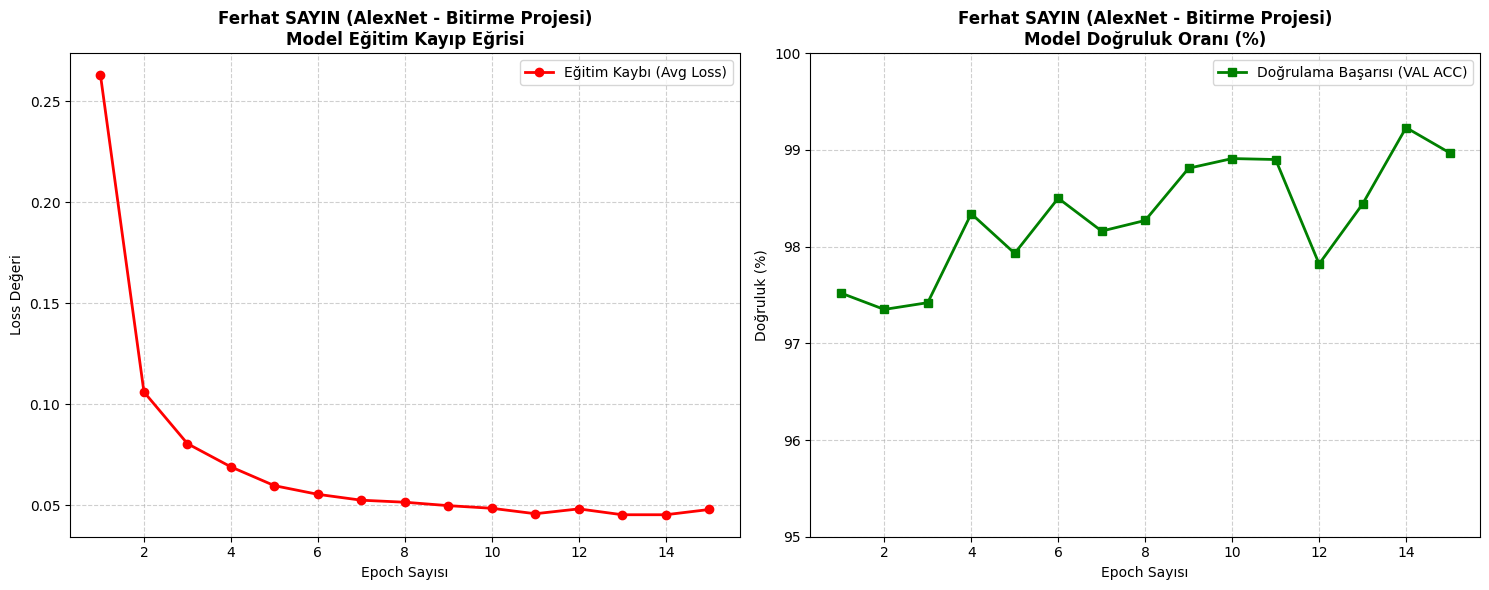

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt


USER_INFO = "Ferhat SAYIN (AlexNet - Bitirme Projesi)"


epochs = list(range(1, 16))
train_losses = [0.2629, 0.1060, 0.0804, 0.0689, 0.0596, 0.0553, 0.0524, 0.0514, 0.0497, 0.0484, 0.0457, 0.0481, 0.0452, 0.0452, 0.0478]
val_accuracies = [97.52, 97.35, 97.42, 98.34, 97.93, 98.50, 98.16, 98.27, 98.81, 98.91, 98.90, 97.82, 98.44, 99.23, 98.97]

plt.figure(figsize=(15, 6))

# 1. Grafik: Eğitim Kaybı (Training Loss)
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r-o', linewidth=2, label='Eğitim Kaybı (Avg Loss)')
plt.title(f'{USER_INFO}\nModel Eğitim Kayıp Eğrisi', fontsize=12, fontweight='bold')
plt.xlabel('Epoch Sayısı')
plt.ylabel('Loss Değeri')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# 2. Grafik: Doğrulama Başarısı (Validation Accuracy)
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, 'g-s', linewidth=2, label='Doğrulama Başarısı (VAL ACC)')
plt.title(f'{USER_INFO}\nModel Doğruluk Oranı (%)', fontsize=12, fontweight='bold')
plt.xlabel('Epoch Sayısı')
plt.ylabel('Doğruluk (%)')
plt.ylim(95, 100) # Başarı çok yüksek olduğu için aralığı daralttık 
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()


plt.savefig('ferhat_sayin_final_grafikler.png')

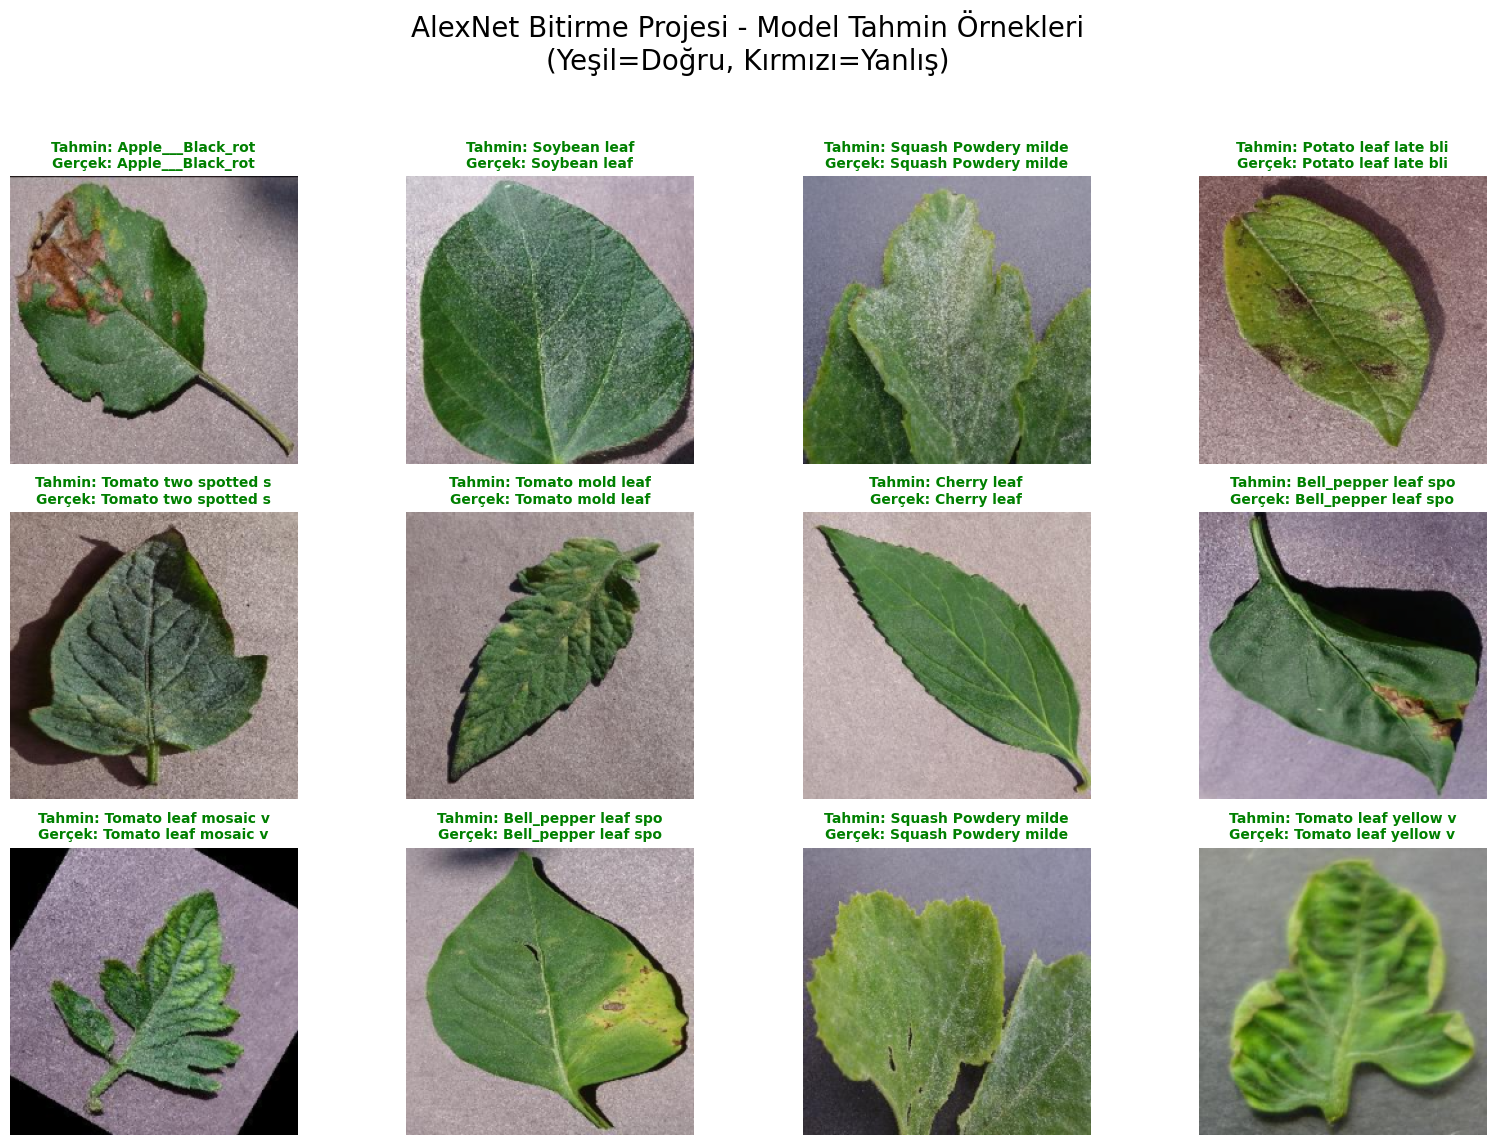

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
import random

def model_show_test(model, dataset, num_images=12):
    model.eval()
    
    # Validation setinden rastgele 12 örnek seçtik
    indices = random.sample(range(len(val_dataset)), num_images)
    subset = Subset(val_dataset, indices)
    dataloader = DataLoader(subset, batch_size=1)
    
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('AlexNet Bitirme Projesi - Model Tahmin Örnekleri\n(Yeşil=Doğru, Kırmızı=Yanlış)', fontsize=20)
    
    idx_to_class = {v: k for k, v in dataset.sinif_sozlugu.items()}

    with torch.no_grad():
        for i, (image, label) in enumerate(dataloader):
            image, label = image.to(device), label.to(device)
            output = model(image)
            _, predicted = torch.max(output, 1)
            
            # Görüntüyü ekrana basalım
            img_display = image.cpu().squeeze(0).permute(1, 2, 0).numpy()
            img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_display = np.clip(img_display, 0, 1)
            
            ax = fig.add_subplot(3, 4, i+1)
            ax.imshow(img_display)
            ax.axis('off')
            
            pred_name = idx_to_class[predicted.item()]
            true_name = idx_to_class[label.item()]
            
            # Yazı rengi
            color = 'green' if predicted.item() == label.item() else 'red'
            
            ax.set_title(f"Tahmin: {pred_name[:20]}\nGerçek: {true_name[:20]}", 
                         color=color, fontsize=10, fontweight='bold')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    fig.savefig('tahmin_ornekleri_gorsel.png')

# Çalıştır
model_show_test(model, dataset)

In [3]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import urllib.parse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# --- 1. AYARLAR (Modelinize göre burayı değiştirin) ---
MODEL_SECIMI = "AlexNet"  
# -------------------------------------------------------

print(f" Sistem hazırlanıyor... Seçilen Model: {MODEL_SECIMI}")

# Dosya Yolları 
CSV_DOSYASI = r"C:\Users\FERHAT\Downloads\egitim_icin_hazir.csv"
ANA_KLASOR = r"C:\Users\FERHAT\Plant\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. VERİ SETİ SINIFINI TEKRAR TANIMLIYORUZ ---
class TankVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}
        
        # Hızlı dosya haritalama
        self.dosya_haritasi = {}
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                tam_yol = os.path.join(root, file)
                self.dosya_haritasi[file] = tam_yol
                duzgun_isim = urllib.parse.unquote(file)
                if duzgun_isim != file:
                    self.dosya_haritasi[duzgun_isim] = tam_yol

    def __len__(self): return len(self.veriler)

    def __getitem__(self, idx):
        try:
            dosya_adi = str(self.veriler.iloc[idx, 0])
            if "?" in dosya_adi: dosya_adi = dosya_adi.split('?')[0]
            hedef_yol = self.dosya_haritasi.get(dosya_adi)
            
            # Bulamazsa alternatif denemeler
            if hedef_yol is None:
                dosya_adi_temiz = urllib.parse.unquote(dosya_adi)
                hedef_yol = self.dosya_haritasi.get(dosya_adi_temiz)
            
            if hedef_yol is None: # Dosya yoksa rastgele başkasını al
                import random
                return self.__getitem__(random.randint(0, len(self.veriler)-1))

            image = Image.open(hedef_yol).convert("RGB")
            label = self.sinif_sozlugu[str(self.veriler.iloc[idx, 1])]
            
            if self.transform: image = self.transform(image)
            return image, label
        except:
            import random
            return self.__getitem__(random.randint(0, len(self.veriler)-1))

# --- 3. VERİLERİ YÜKLÜYORUZ ---
print(" Veri seti yükleniyor (Loader oluşturuluyor)...")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

try:
    # Veri setini oluştur
    dataset = TankVeriSeti(csv_file=CSV_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
    
    # Train/Test ayır (%20 Test)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    _, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    
    # Loader'ı oluşturma
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    print(f" Loader başarıyla oluşturuldu! Test edilecek resim sayısı: {len(val_dataset)}")
    
except Exception as e:
    print(f" Veri yükleme hatası: {e}")
    print("Lütfen dosya yollarının (CSV ve Klasör) doğru olduğunu kontrol edin.")

# --- 4. MODELİ KONTROL EDİYORUZ ---
if 'model' not in globals():
    print(" UYARI: 'model' değişkeni bulunamadı. Lütfen model tanımlama ve yükleme hücrelerini yukarıdan çalıştırın.")
    print("Bu kod sadece veri setini geri getirdi. Modeli çalıştırmak için modelin yüklü olması şarttır.")
else:
    print(" Model hafızada mevcut, grafik işlemine geçiliyor...")

    # --- 5.GRAFİKLER ---
    all_preds = []
    all_labels = []
    model.eval()
    model.to(DEVICE)

    print(" Tahminler hesaplanıyor (Bu işlem biraz sürebilir)...")
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # A) CONFUSION MATRIX
    print("\n Confusion Matrix çiziliyor...")
    plt.figure(figsize=(24, 20))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=dataset.sinif_isimleri, yticklabels=dataset.sinif_isimleri)
    plt.title(f"{MODEL_SECIMI} - Confusion Matrix", fontsize=24)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # B) PIE CHART
    print("\n Sınıf Dağılımı (Pie Chart) çiziliyor...")
    plt.figure(figsize=(12, 12))
    counts = dataset.veriler['class'].value_counts()
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 8})
    plt.title("Veri Seti Sınıf Dağılımı", fontsize=16)
    plt.tight_layout()
    plt.show()

    # C) EXCEL RAPORU
    print("\n Excel Tablosu kaydediliyor...")
    report_dict = classification_report(all_labels, all_preds, target_names=dataset.sinif_isimleri, output_dict=True)
    df = pd.DataFrame(report_dict).transpose()
    df_clean = df.iloc[:-3, :][['precision', 'recall', 'f1-score', 'support']]
    df_clean.to_excel(f"{MODEL_SECIMI}_Detayli_Rapor.xlsx")
    print(f" Dosya kaydedildi: {MODEL_SECIMI}_Detayli_Rapor.xlsx")

 Sistem hazırlanıyor... Seçilen Model: AlexNet
 Veri seti yükleniyor (Loader oluşturuluyor)...
 Loader başarıyla oluşturuldu! Test edilecek resim sayısı: 15753
 UYARI: 'model' değişkeni bulunamadı. Lütfen model tanımlama ve yükleme hücrelerini yukarıdan çalıştırın.
Bu kod sadece veri setini geri getirdi. Modeli çalıştırmak için modelin yüklü olması şarttır.


Islem Basliyor: AlexNet - Cihaz: cuda
Veri seti hazirlaniyor...
Test verisi sayisi: 15753


C:\Users\FERHAT\AppData\Local\Temp\ipykernel_4392\2761093419.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=

Model agirliklari yuklendi.
Tahminler aliniyor...


100%|████████████████████████████████████████████████████████████████████████████████| 985/985 [01:02<00:00, 15.78it/s]


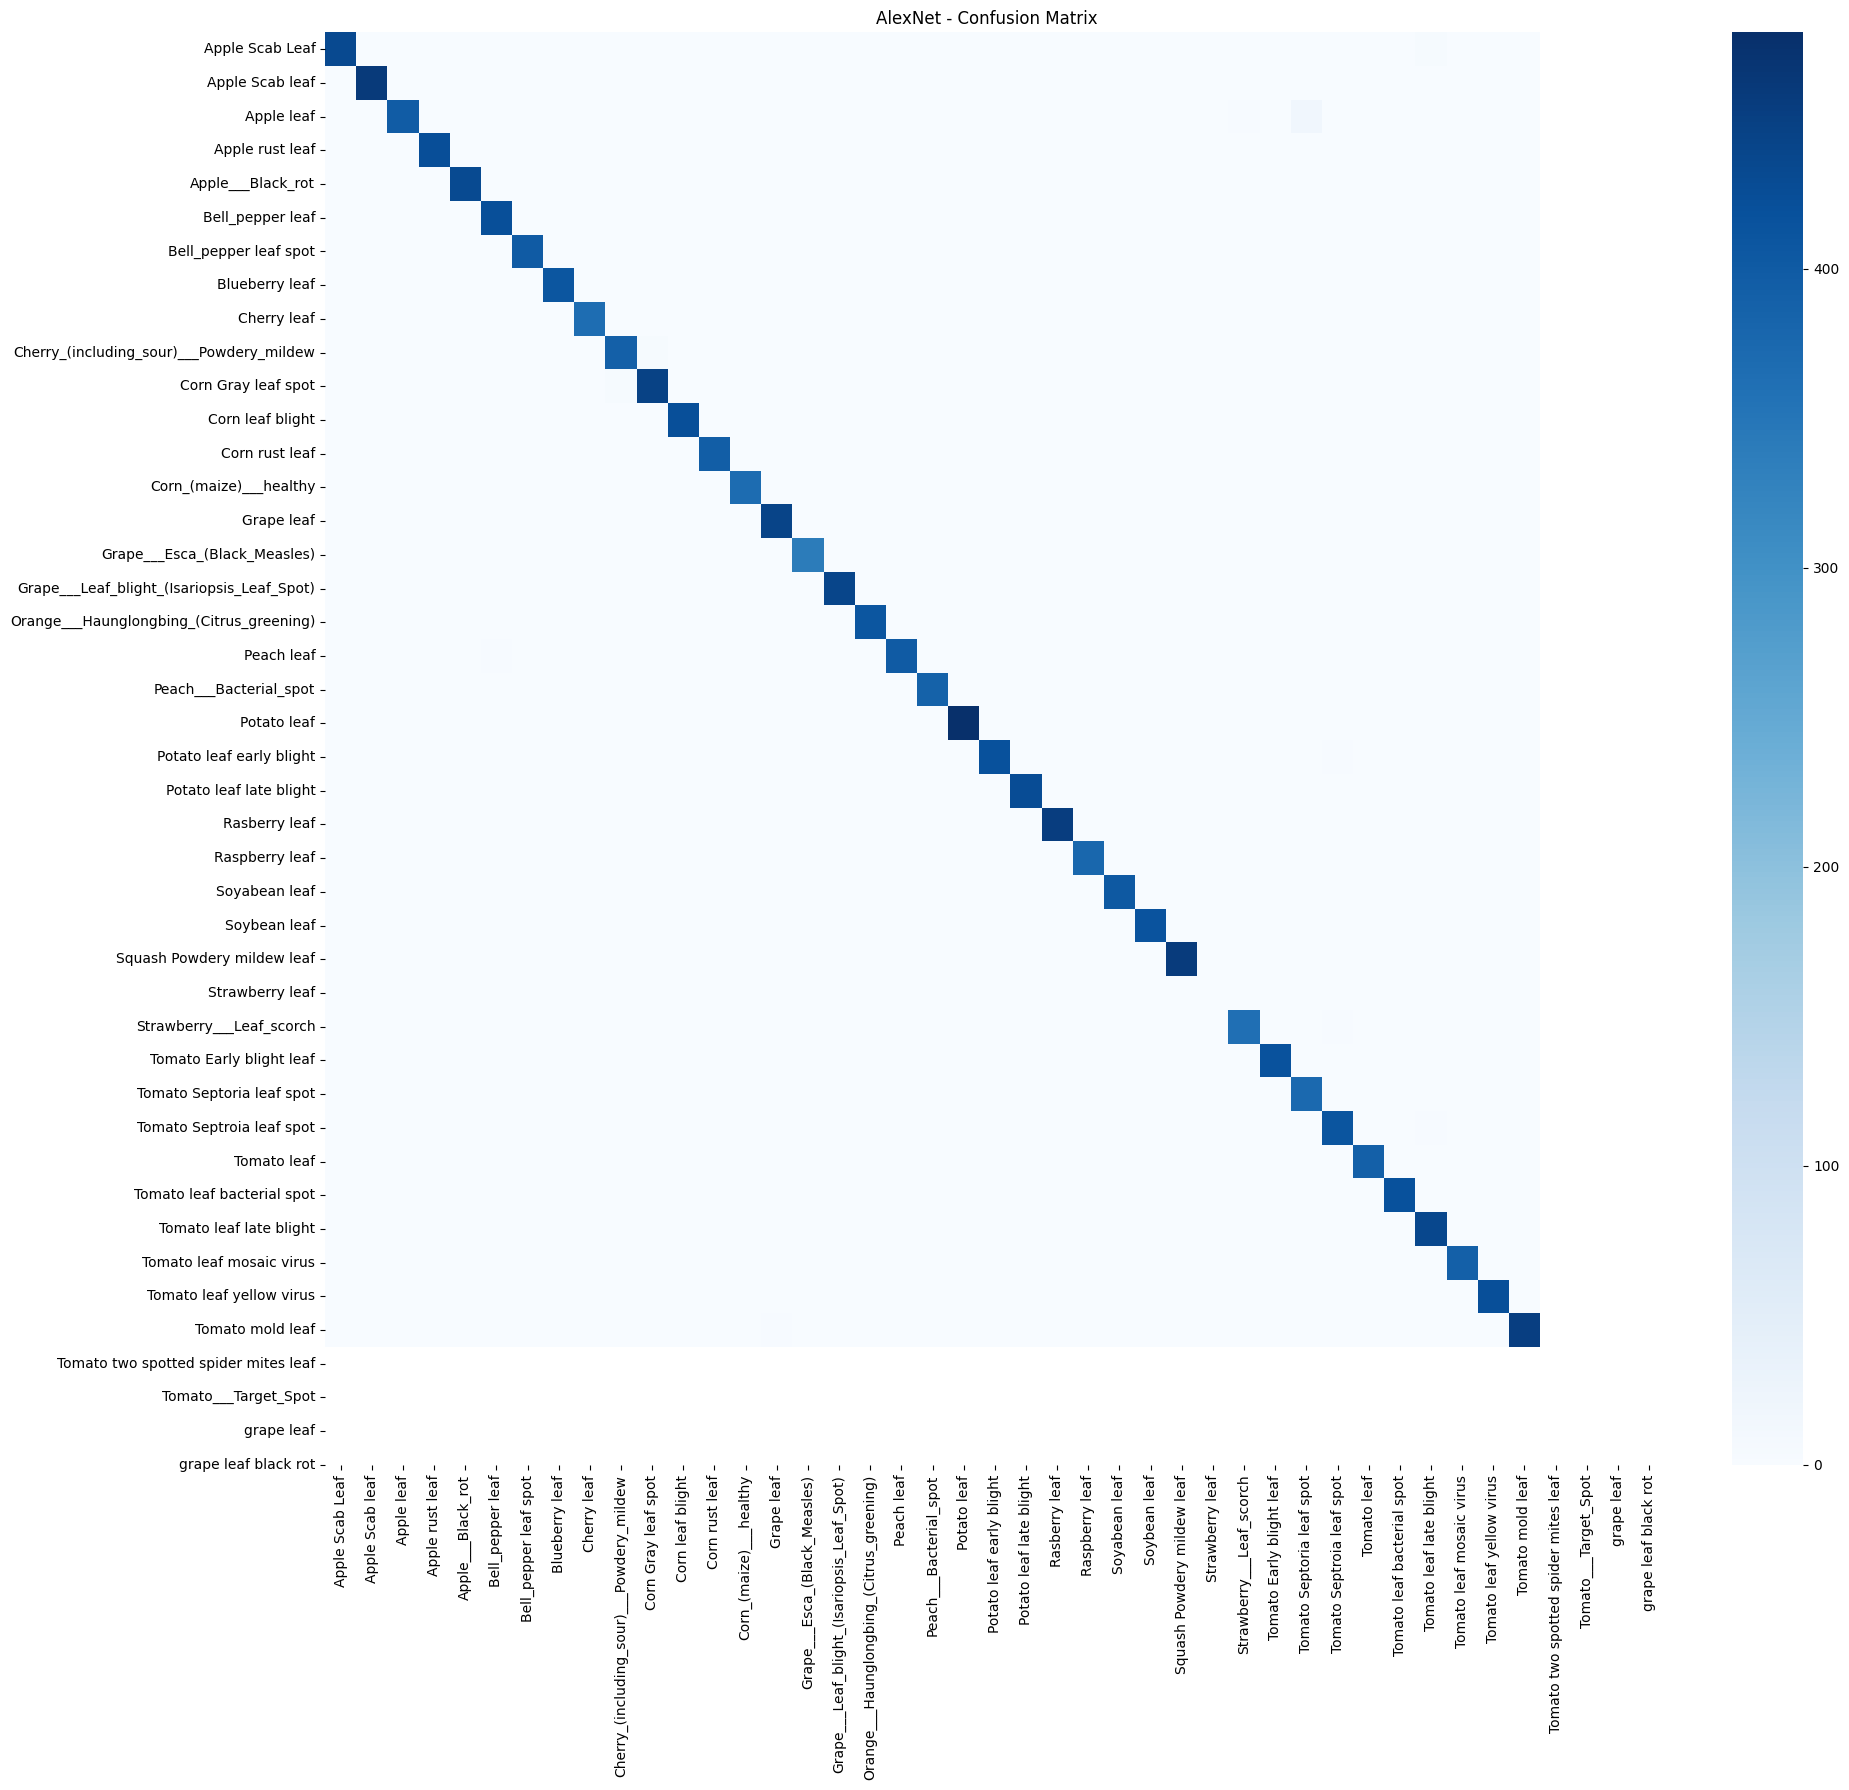

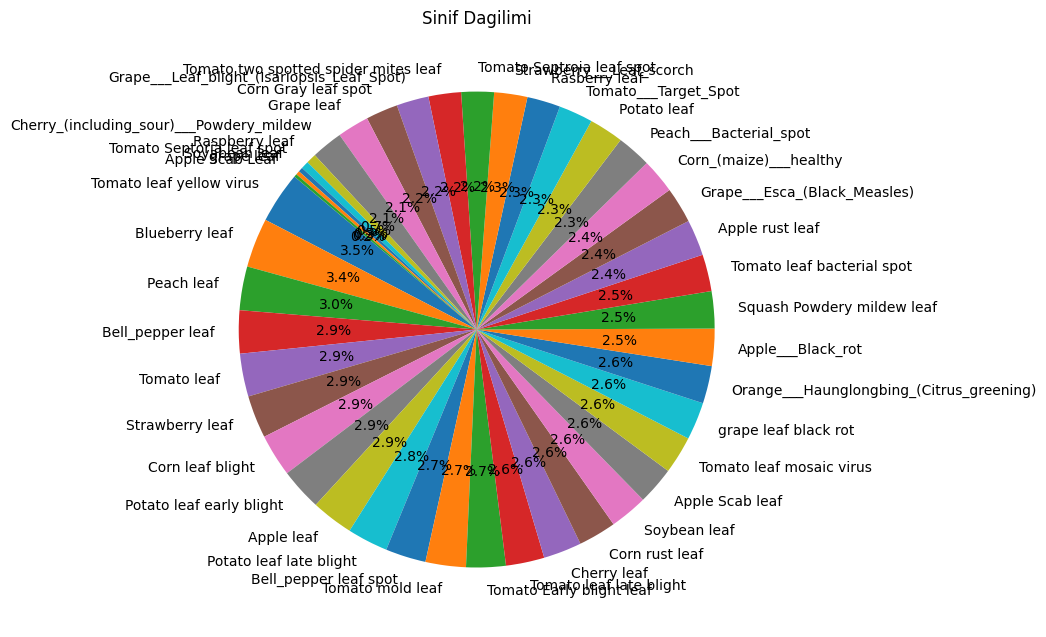

Bir hata olustu: Number of classes, 39, does not match size of target_names, 43. Try specifying the labels parameter


In [4]:
import os
import urllib.parse
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# --- 1. AYARLAR VE SABİTLER ---
MODEL_ADI = "AlexNet"
CSV_DOSYASI = r"C:\Users\FERHAT\Downloads\egitim_icin_hazir.csv"
ANA_KLASOR = r"C:\Users\FERHAT\Plant\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train"
MODEL_PATH = r"C:\Users\FERHAT\alexnet_model_final.pth"
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Islem Basliyor: {MODEL_ADI} - Cihaz: {DEVICE}")

# --- 2. VERİ SETİ SINIFI ---
class TankVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}
        
        self.dosya_haritasi = {}
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                tam_yol = os.path.join(root, file)
                self.dosya_haritasi[file] = tam_yol
                duzgun_isim = urllib.parse.unquote(file)
                if duzgun_isim != file:
                    self.dosya_haritasi[duzgun_isim] = tam_yol

    def __len__(self): return len(self.veriler)

    def __getitem__(self, idx):
        try:
            dosya_adi = str(self.veriler.iloc[idx, 0]).split('?')[0]
            hedef_yol = self.dosya_haritasi.get(dosya_adi)
            
            if hedef_yol is None:
                hedef_yol = self.dosya_haritasi.get(urllib.parse.unquote(dosya_adi))
            
            if hedef_yol is None:
                return self.__getitem__(random.randint(0, len(self.veriler)-1))

            image = Image.open(hedef_yol).convert("RGB")
            label = self.sinif_sozlugu[str(self.veriler.iloc[idx, 1])]
            
            if self.transform: image = self.transform(image)
            return image, label
        except:
            return self.__getitem__(random.randint(0, len(self.veriler)-1))

# --- 3. MODEL MİMARİSİ (ALEXNET) ---
class AlexNetModel(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetModel, self).__init__()
        self.model = models.alexnet(weights=None)
        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        return self.model(x)

# --- 4. ANA İŞLEM AKIŞI ---
if __name__ == '__main__':
    # A) Veri Yukleme
    print("Veri seti hazirlaniyor...")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    try:
        dataset = TankVeriSeti(csv_file=CSV_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        _, val_dataset = random_split(dataset, [train_size, val_size], 
                                    generator=torch.Generator().manual_seed(42))
        
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        print(f"Test verisi sayisi: {len(val_dataset)}")
        
        # B) Model Kurulumu
        num_classes = len(dataset.sinif_isimleri)
        model = AlexNetModel(num_classes=num_classes).to(DEVICE)
        
        if os.path.exists(MODEL_PATH):
            model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
            print("Model agirliklari yuklendi.")
        else:
            print(f"HATA: Model dosyasi bulunamadi ({MODEL_PATH})")
            exit()

        # C) Tahmin Alma
        print("Tahminler aliniyor...")
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # D) Raporlama ve Grafikler
        
        # 1. Confusion Matrix
        plt.figure(figsize=(20, 18))
        cm = confusion_matrix(all_labels, all_preds)
        sns.heatmap(cm, annot=False, cmap="Blues", 
                    xticklabels=dataset.sinif_isimleri, 
                    yticklabels=dataset.sinif_isimleri)
        plt.title(f"{MODEL_ADI} - Confusion Matrix")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

        # 2. Pie Chart
        plt.figure(figsize=(10, 10))
        counts = dataset.veriler['class'].value_counts()
        plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
        plt.title("Sinif Dagilimi")
        plt.tight_layout()
        plt.show()

        # 3. Excel Raporu
        report_dict = classification_report(all_labels, all_preds, 
                                          target_names=dataset.sinif_isimleri, 
                                          output_dict=True)
        df = pd.DataFrame(report_dict).transpose()
        df_clean = df.iloc[:-3, :][['precision', 'recall', 'f1-score', 'support']]
        df_clean.to_excel(f"{MODEL_ADI}_Detayli_Rapor.xlsx")
        print(f"Rapor kaydedildi: {MODEL_ADI}_Detayli_Rapor.xlsx")

    except Exception as e:
        print(f"Bir hata olustu: {e}")

In [9]:
!pip install openpyxl

Islem Basliyor: AlexNet - Cihaz: cuda
Veri seti hazirlaniyor...
CSV dosyasındaki sınıf sayısı: 43


C:\Users\FERHAT\AppData\Local\Temp\ipykernel_4392\2109498357.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=

Model agirliklari basariyla yuklendi.
Tahminler aliniyor...


100%|████████████████████████████████████████████████████████████████████████████████| 985/985 [00:55<00:00, 17.86it/s]


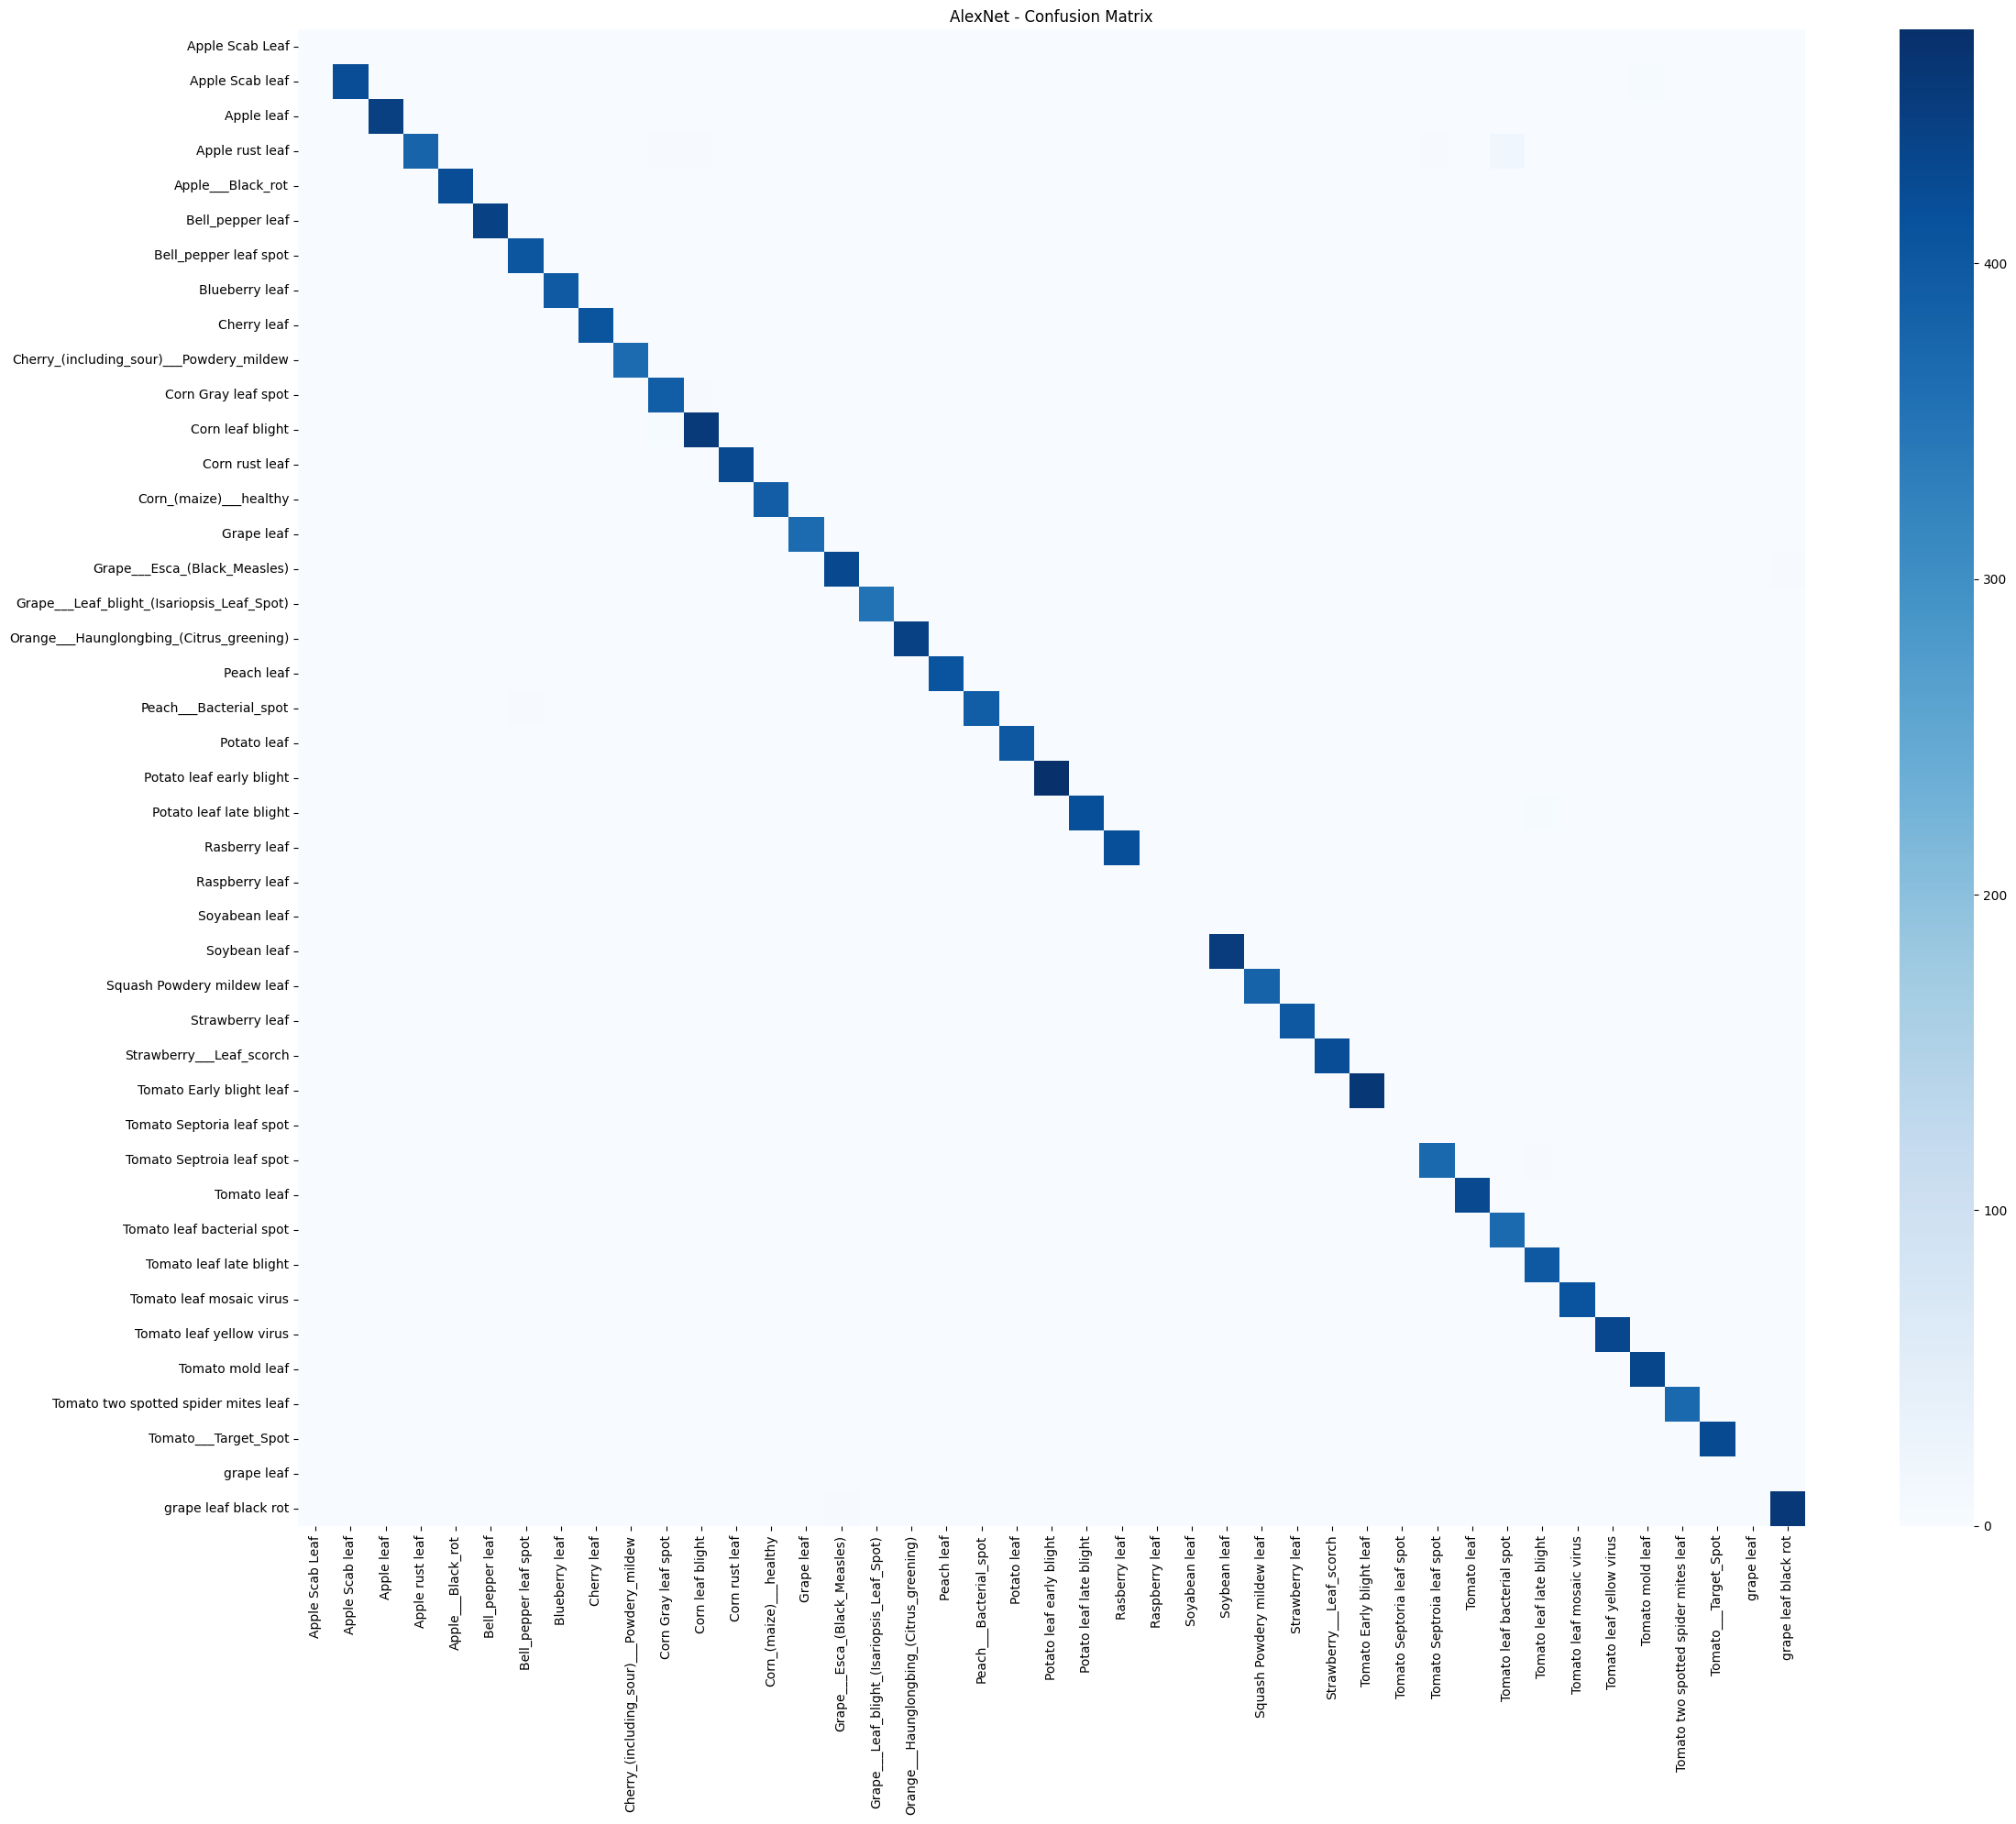

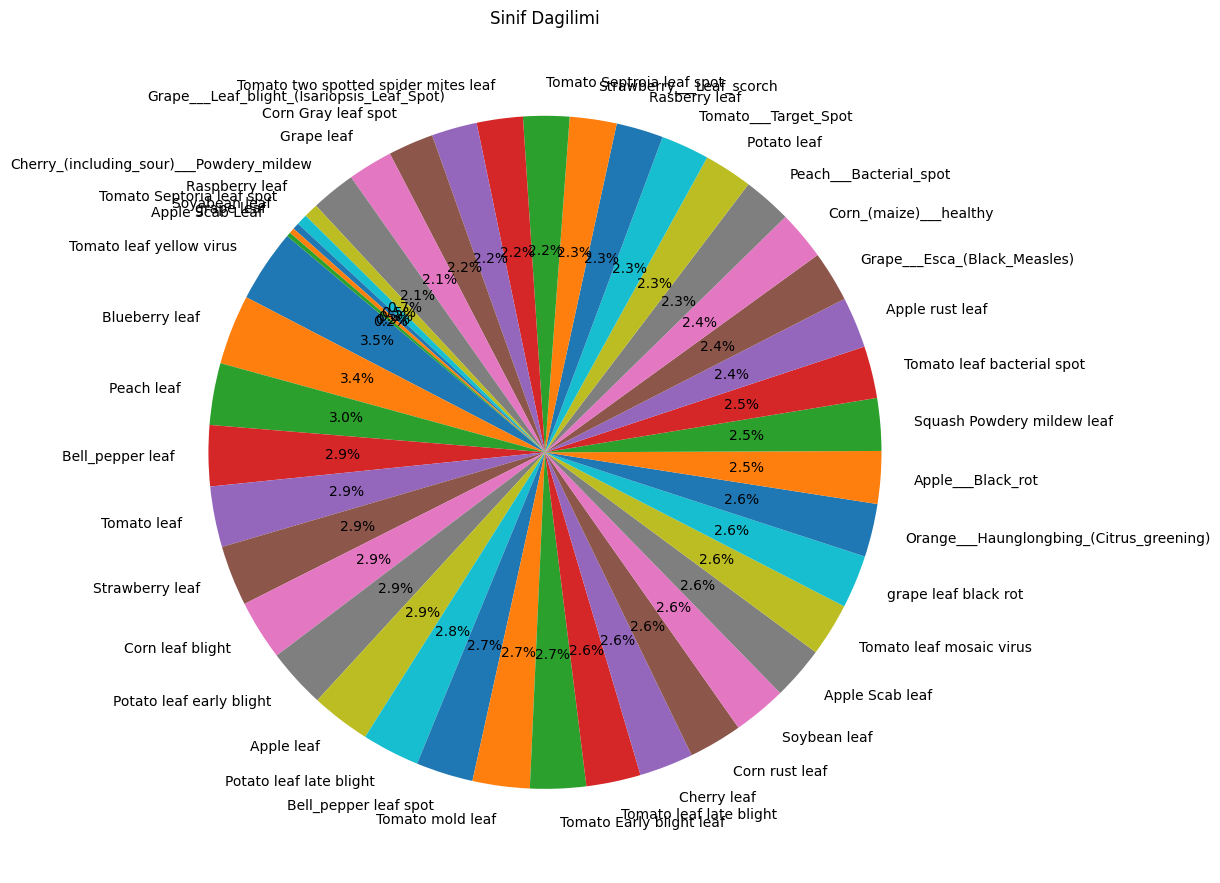

 Rapor basariyla kaydedildi: AlexNet_Detayli_Rapor.xlsx


In [10]:
import os
import urllib.parse
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# --- 1. AYARLAR ---
MODEL_ADI = "AlexNet"
# CSV dosyanızın yolu
CSV_DOSYASI = r"C:\Users\FERHAT\Downloads\egitim_icin_hazir.csv"
# Resimlerin olduğu klasör
ANA_KLASOR = r"C:\Users\FERHAT\Plant\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train"
# Model dosyasının yolu
MODEL_PATH = r"C:\Users\FERHAT\alexnet_model_final.pth"

BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelin orijinal eğitimindeki sınıf sayısı 
ORIJINAL_EGITIM_SINIF_SAYISI = 43 

print(f"Islem Basliyor: {MODEL_ADI} - Cihaz: {DEVICE}")

# --- 2. VERİ SETİ SINIFI ---
class TankVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}
        
        # Dosya yollarını bulma
        self.dosya_haritasi = {}
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                tam_yol = os.path.join(root, file)
                self.dosya_haritasi[file] = tam_yol
                
                duzgun_isim = urllib.parse.unquote(file)
                if duzgun_isim != file:
                    self.dosya_haritasi[duzgun_isim] = tam_yol

    def __len__(self): return len(self.veriler)

    def __getitem__(self, idx):
        try:
            dosya_adi = str(self.veriler.iloc[idx, 0]).split('?')[0]
            hedef_yol = self.dosya_haritasi.get(dosya_adi)
            
            if hedef_yol is None:
                hedef_yol = self.dosya_haritasi.get(urllib.parse.unquote(dosya_adi))
            
            if hedef_yol is None:
                # Dosya bulunamazsa rastgele bir tane döndür (Hata vermemesi için)
                return self.__getitem__(random.randint(0, len(self.veriler)-1))

            image = Image.open(hedef_yol).convert("RGB")
            # Label indexi (0-38 arası)
            label = self.sinif_sozlugu[str(self.veriler.iloc[idx, 1])]
            
            if self.transform: image = self.transform(image)
            return image, label
        except:
            return self.__getitem__(random.randint(0, len(self.veriler)-1))

# --- 3. MODEL MİMARİSİ ---
class AlexNetModel(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetModel, self).__init__()
        self.model = models.alexnet(weights=None)
        num_ftrs = self.model.classifier[6].in_features
        # Model yüklenirken hata vermemesi için 43 yapıyoruz
        self.model.classifier[6] = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        return self.model(x)

# --- 4. ANA İŞLEM ---
if __name__ == '__main__':
    print("Veri seti hazirlaniyor...")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    try:
        # Veri setini yükle
        dataset = TankVeriSeti(csv_file=CSV_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
        print(f"CSV dosyasındaki sınıf sayısı: {len(dataset.sinif_isimleri)}")
        
        # Test seti ayır
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        _, val_dataset = random_split(dataset, [train_size, val_size], 
                                    generator=torch.Generator().manual_seed(42))
        
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        # Modeli başlat 
        model = AlexNetModel(num_classes=ORIJINAL_EGITIM_SINIF_SAYISI).to(DEVICE)
        
        if os.path.exists(MODEL_PATH):
            try:
                model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
                print("Model agirliklari basariyla yuklendi.")
            except RuntimeError as e:
                print("Model boyutu uyuşmazlığı hatası. Sınıf sayısını kontrol ediyoruz...")
                # Eğer 43 değilse, dataset boyutuyla (39) tekrar dene
                model = AlexNetModel(num_classes=len(dataset.sinif_isimleri)).to(DEVICE)
                model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
                print("Model agirliklari (Dataset boyutuna göre) yuklendi.")
        else:
            print(f"HATA: Model dosyasi bulunamadi ({MODEL_PATH})")
            exit()

        print("Tahminler aliniyor...")
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)
                
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        
        # Sadece veri setinde var olan etiketler için rapor oluştur
        mevcut_etiketler = list(range(len(dataset.sinif_isimleri)))

        # 1. Confusion Matrix
        plt.figure(figsize=(24, 20))
        cm = confusion_matrix(all_labels, all_preds, labels=mevcut_etiketler)
        sns.heatmap(cm, annot=False, cmap="Blues", 
                    xticklabels=dataset.sinif_isimleri, 
                    yticklabels=dataset.sinif_isimleri)
        plt.title(f"{MODEL_ADI} - Confusion Matrix")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

        # 2. Pie Chart
        plt.figure(figsize=(12, 12))
        counts = dataset.veriler['class'].value_counts()
        plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
        plt.title("Sinif Dagilimi")
        plt.tight_layout()
        plt.show()

        # 3. Excel Raporu 
        report_dict = classification_report(all_labels, all_preds, 
                                          target_names=dataset.sinif_isimleri, 
                                          labels=mevcut_etiketler, # HATA BURADA ÇÖZÜLÜYOR
                                          output_dict=True,
                                          zero_division=0)
        
        df = pd.DataFrame(report_dict).transpose()
        df_clean = df.iloc[:-3, :][['precision', 'recall', 'f1-score', 'support']]
        df_clean.to_excel(f"{MODEL_ADI}_Detayli_Rapor.xlsx")
        print(f" Rapor basariyla kaydedildi: {MODEL_ADI}_Detayli_Rapor.xlsx")

    except Exception as e:
        print(f"Bir hata olustu: {e}")